In [1]:
import glob
import numpy as np
import pandas as pd
import uproot
import yaml
import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import magicctapipe

print(magicctapipe.__version__)

0.3.0


In [4]:
school_directory = "/fefs/aswg/workspace/2023_joint_analysis_school"
school_directory = "/home/mpp/Software_School_2023/data/2023_joint_analysis_school"

magic_calibrated_files = f"{school_directory}/DL0_to_DL1/input/20*_Y_*.root"

One can have a look within the calibrated ROOT files using the uproot module, and check which trees are there:

In [9]:
rootf = uproot.open(sorted(glob.glob(magic_calibrated_files))[0])
print(rootf.keys())
rootf.close()

['Events;3', 'Events;2', 'RunHeaders;1', 'RunTails;1', 'Pedestals;1', 'Camera;1', 'Trigger;1', 'L3T;1', 'Drive;1', 'CC;1', 'Starguider;1', 'DT;1', 'Pyrometer;1', 'DAQ;1', 'AMC;1', 'SUMO;1', 'SumTrigger;1', 'Lidar;1', 'Laser;1', 'Weather;1', 'Pulsar;1', 'Cal;1', 'Cooling;1', 'GFS;1']


Then, we can for example check one calibrated image (both charge and times).
We do this using the **MAGICEventSource**, which converts the MAGIC ROOT data format in something that ctapipe can process.
MAGICEventSource is part of _ctapipe_io_magic_ module, aka MAGIC reader.

We use **EventSeeker** to get a random event, in this case the 763rd event in the list.
The **CameraDisplay** utility of ctapipe is used to visualize the event charge and times in the camera.

Seeking event by iterating through events.. (potentially long process)
Interpolating cosmic events information from 17 drive reports.
Drive reports available from 2021-02-13 21:46:33.053 to 2021-02-13 21:48:44.467.


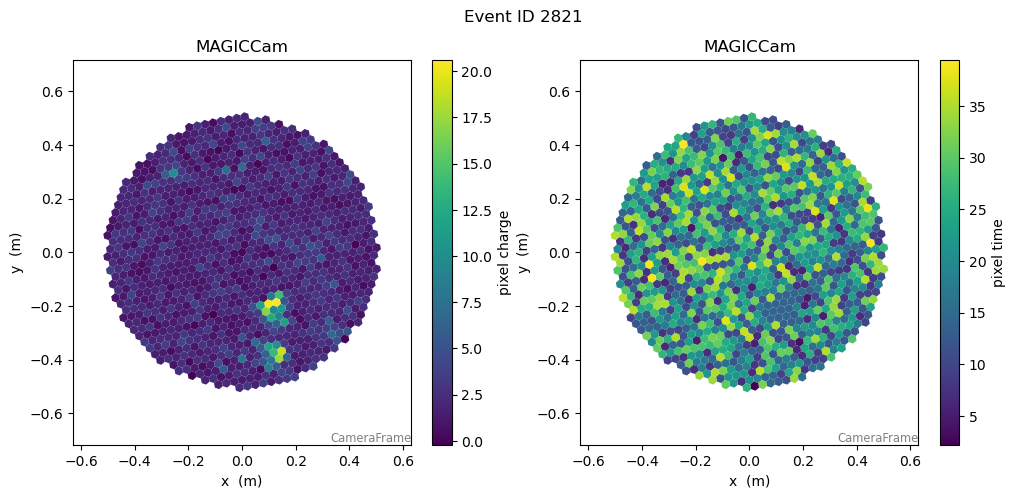

In [5]:
from ctapipe_io_magic import MAGICEventSource
from ctapipe.visualization import CameraDisplay
from ctapipe.io import EventSeeker

event_source = MAGICEventSource(
    input_url=sorted(glob.glob(magic_calibrated_files))[0],
    process_run=False,
)

subarray = event_source.subarray
camera_geometry = subarray.tel[2].camera.geometry

seeker = EventSeeker(event_source=event_source)
event = seeker.get_event_index(763)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle(f"Event ID {event.index.event_id}")

disp1 = CameraDisplay(camera_geometry, ax = ax1)
disp2 = CameraDisplay(camera_geometry, ax = ax2)
disp1.add_colorbar(label="pixel charge")
disp2.add_colorbar(label="pixel time")

#print(event)

event_image = event.dl1.tel[2].image
event_times = event.dl1.tel[2].peak_time

disp1.image = event_image
disp2.image = event_times
disp1.set_limits_minmax(0, np.amax(event_image))
disp2.set_limits_minmax(0, np.amax(event_times))

Then we proceed with the image cleaning, using the one provided by magic-cta-pipe, which was ported from the
MAGIC proprietary software in python. Also, we compute the hillas parameters and overlay the hillas ellipse
on the event.

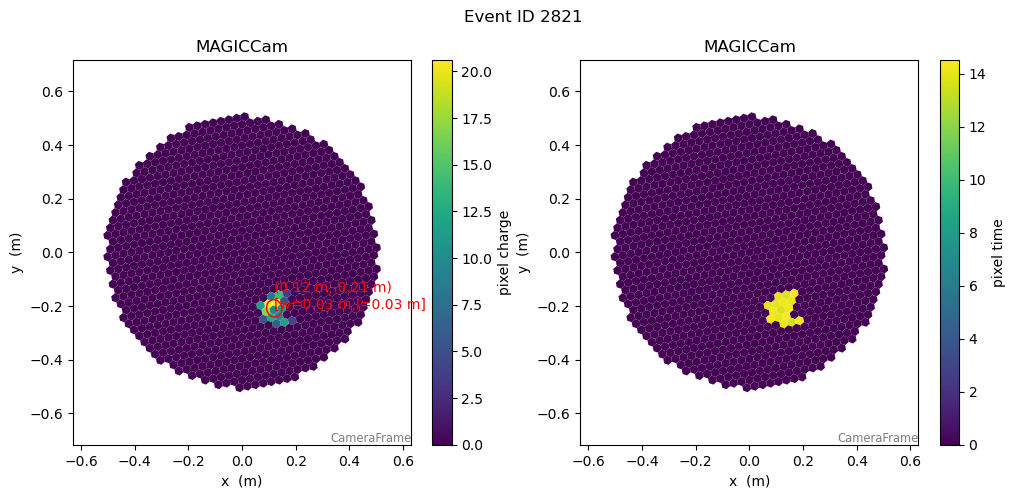

In [11]:
from magicctapipe.image import MAGICClean
from ctapipe.image import hillas_parameters

cleaning_config = dict(
    picture_thresh=6.0,
    boundary_thresh=3.5,
    max_time_off=4.5,
    max_time_diff=1.5,
    use_time=True,
    use_sum=True,
    find_hotpixels=True,
)

magic_clean = MAGICClean(camera_geometry, cleaning_config)

badrmspixel_mask = event.mon.tel[2].pixel_status.pedestal_failing_pixels[2]
deadpixel_mask = event.mon.tel[2].pixel_status.hardware_failing_pixels[0]
unsuitable_mask = np.logical_or(badrmspixel_mask, deadpixel_mask)
event_image_copy = event_image.copy()
event_times_copy = event_times.copy()
(
    clean_mask,
    event_image_cleaned,
    event_times_cleaned,
) = magic_clean.clean_image(
    event_image_copy,
    event_times_copy,
    unsuitable_mask=unsuitable_mask,
)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(12)
fig.suptitle(f"Event ID {event.index.event_id}")

disp1 = CameraDisplay(camera_geometry, ax = ax1)
disp2 = CameraDisplay(camera_geometry, ax = ax2)
disp1.add_colorbar(label="pixel charge")
disp2.add_colorbar(label="pixel time")

event_image_cleaned[~clean_mask] = 0
event_times_cleaned[~clean_mask] = 0

disp1.image = event_image_cleaned
disp2.image = event_times_cleaned
#disp1.highlight_pixels(clean_mask, color="red", alpha=1, linewidth=1)
hillas = hillas_parameters(camera_geometry, event_image_cleaned)
disp1.overlay_moments(hillas, color="red", linewidth=1, zorder=10)
#disp2.highlight_pixels(clean_mask, color="red", alpha=1, linewidth=1)
disp1.set_limits_minmax(0, np.amax(event_image_cleaned))
disp2.set_limits_minmax(0, np.amax(event_times_cleaned))

Now we run _magic_calib_to_dl1_ script. It is the script that takes in MAGIC ROOT files and converts them into DL1 format,
performing cleaning, hillas parameters computation etc.

In [12]:
!magic_calib_to_dl1 --help

usage: magic_calib_to_dl1 [-h] --input-file INPUT_FILE
                          [--output-dir OUTPUT_DIR]
                          [--config-file CONFIG_FILE] [--process-run]

optional arguments:
  -h, --help            show this help message and exit
  --input-file INPUT_FILE, -i INPUT_FILE
                        Path to an input MAGIC calibrated data file
  --output-dir OUTPUT_DIR, -o OUTPUT_DIR
                        Path to a directory where to save an output DL1 data
                        file
  --config-file CONFIG_FILE, -c CONFIG_FILE
                        Path to a configuration file
  --process-run         Process the events of all the subrun files at once


In [5]:
input_file = sorted(glob.glob(magic_calibrated_files))[0]
config_file = f"{school_directory}/DL0_to_DL1/input/config.yaml"
output_dir = "./output"

In [6]:
with open(config_file, 'rb') as f:
    config = yaml.safe_load(f)

We can check the cleaning settings for MAGIC:

In [9]:
config["MAGIC"]["magic_clean"]

{'use_time': True,
 'use_sum': True,
 'picture_thresh': 6,
 'boundary_thresh': 3.5,
 'max_time_off': 4.5,
 'max_time_diff': 1.5,
 'find_hotpixels': True,
 'pedestal_type': 'from_extractor_rndm'}

In [14]:
!magic_calib_to_dl1\
--input-file $input_file\
--output-dir $output_dir\
--config-file $config_file\
--process-run


Input file: /home/mpp/Software_School_2023/data/2023_joint_analysis_school/DL0_to_DL1/input/20210214_M2_05094483.001_Y_CrabNebula-W0.40+215.root

Is simulation: False

Observation ID: 5094483
Telescope ID: 2

Is stereo trigger: True
Is SUM trigger: False

The following files are found to read drive reports:
/home/mpp/Software_School_2023/data/2023_joint_analysis_school/DL0_to_DL1/input/20210214_M2_05094483.001_Y_CrabNebula-W0.40+215.root
/home/mpp/Software_School_2023/data/2023_joint_analysis_school/DL0_to_DL1/input/20210214_M2_05094483.002_Y_CrabNebula-W0.40+215.root

Process run: True

MAGIC image cleaning:
    use_time: True
    use_sum: True
    picture_thresh: 6
    boundary_thresh: 3.5
    max_time_off: 4.5
    max_time_diff: 1.5
    find_hotpixels: True
    pedestal_type: from_extractor_rndm 

Processing the events...
Interpolating cosmic events information from 17 drive reports.
Drive reports available from 2021-02-13 21:46:33.053 to 2021-02-13 21:48:44.467.
0 events
--> 5 eve

In [15]:
!ls $output_dir

dl1_M2.Run05094483.h5


Now let's check the output file.

In [18]:
output_file = f"{output_dir}/dl1_M2.Run05094483.h5"
data = pd.read_hdf(output_file, key='events/parameters')
data.head()

,obs_id,event_id,tel_id,pointing_alt,pointing_az,n_pixels,n_islands,time_sec,time_nanosec,time_diff,...,width,width_uncertainty,psi,intercept,deviation,slope,pixels_width_1,pixels_width_2,intensity_width_1,intensity_width_2
0,5094483,2014,3,1.380486,4.056769,14,1,1613252793,893311600,0.008463,...,0.022307,0.001016,-34.681800,18.121713,0.439559,3.648434,0.0,0.0,0.0,0.0
1,5094483,2015,3,1.380486,4.056770,11,1,1613252793,894960200,0.001648,...,0.015624,0.000840,-74.046671,14.787732,0.513162,-6.164529,0.0,0.0,0.0,0.0
2,5094483,2016,3,1.380486,4.056770,9,1,1613252793,895270800,0.000311,...,0.016342,0.001041,24.829162,16.632719,0.235342,2.581555,0.0,0.0,0.0,0.0
3,5094483,2017,3,1.380486,4.056770,13,1,1613252793,897536600,0.002266,...,0.016850,0.001106,47.463710,15.150236,0.586330,1.210617,0.0,0.0,0.0,0.0
4,5094483,2018,3,1.380486,4.056770,4,1,1613252793,898158000,0.000621,...,0.010902,0.000913,37.225918,15.053317,0.516259,17.728797,0.0,0.0,0.0,0.0


In [19]:
data.columns

Index(['obs_id', 'event_id', 'tel_id', 'pointing_alt', 'pointing_az',
       'n_pixels', 'n_islands', 'time_sec', 'time_nanosec', 'time_diff',
       'intensity', 'skewness', 'kurtosis', 'x', 'y', 'r', 'phi', 'length',
       'length_uncertainty', 'width', 'width_uncertainty', 'psi', 'intercept',
       'deviation', 'slope', 'pixels_width_1', 'pixels_width_2',
       'intensity_width_1', 'intensity_width_2'],
      dtype='object')

We can produce different plots e.g. distribution of intensity.

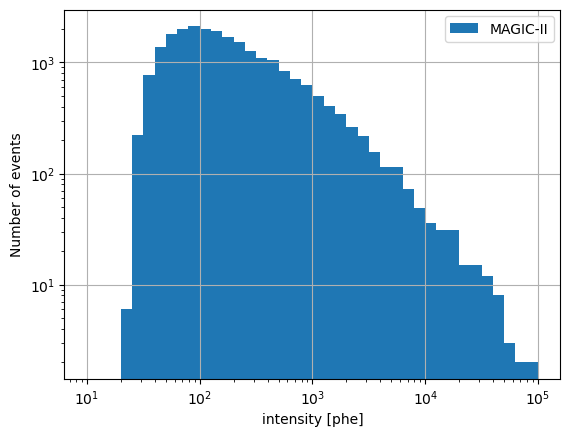

In [22]:
plt.figure()
plt.xlabel('intensity [phe]')
plt.ylabel('Number of events')
plt.loglog()

plt.hist(data['intensity'].to_numpy(), bins=np.logspace(1, 5, 41), label='MAGIC-II')

plt.grid()
plt.legend()

Now let's look at some MC data with both LST1 and MAGIC simulated. We take one a file at DL0 level, and we process
it to go to DL1 level.

In [23]:
mc_dl0_file = f"{school_directory}/DL0_to_DL1/input/simtel_corsika_theta_10.0_az_102.199_run1.simtel.gz"

In [25]:
!lst1_magic_mc_dl0_to_dl1 --help

usage: lst1_magic_mc_dl0_to_dl1 [-h] --input-file INPUT_FILE
                                [--output-dir OUTPUT_DIR]
                                [--config-file CONFIG_FILE]

optional arguments:
  -h, --help            show this help message and exit
  --input-file INPUT_FILE, -i INPUT_FILE
                        Path to an input simtel MC DL0 data file
  --output-dir OUTPUT_DIR, -o OUTPUT_DIR
                        Path to a directory where to save an output DL1 data
                        file
  --config-file CONFIG_FILE, -c CONFIG_FILE
                        Path to a configuration file


We can check the settings for LST1 and MAGIC:

In [12]:
config["LST"]

{'image_extractor': {'type': 'LocalPeakWindowSum',
  'window_shift': 4,
  'window_width': 8},
 'increase_nsb': {'use': True,
  'extra_noise_in_dim_pixels': 1.27,
  'extra_bias_in_dim_pixels': 0.665,
  'transition_charge': 8,
  'extra_noise_in_bright_pixels': 2.08},
 'increase_psf': {'use': False, 'fraction': None},
 'tailcuts_clean': {'picture_thresh': 8,
  'boundary_thresh': 4,
  'keep_isolated_pixels': False,
  'min_number_picture_neighbors': 2},
 'time_delta_cleaning': {'use': True,
  'min_number_neighbors': 1,
  'time_limit': 2},
 'dynamic_cleaning': {'use': True, 'threshold': 267, 'fraction': 0.03},
 'use_only_main_island': False}

In [13]:
config["MAGIC"]

{'image_extractor': {'type': 'SlidingWindowMaxSum',
  'window_width': 5,
  'apply_integration_correction': False},
 'charge_correction': {'use': True, 'factor': 1.143},
 'magic_clean': {'use_time': True,
  'use_sum': True,
  'picture_thresh': 6,
  'boundary_thresh': 3.5,
  'max_time_off': 4.5,
  'max_time_diff': 1.5,
  'find_hotpixels': True,
  'pedestal_type': 'from_extractor_rndm'},
 'muon_ring': {'thr_low': 25,
  'tailcut': [12, 8],
  'ring_completeness_threshold': 25}}

In [26]:
!lst1_magic_mc_dl0_to_dl1\
--input-file $mc_dl0_file\
--output-dir $output_dir\
--config-file $config_file


Assigned telescope IDs:
    LST-1: 1
    MAGIC-I: 2
    MAGIC-II: 3 

Input file: /home/mpp/Software_School_2023/data/2023_joint_analysis_school/DL0_to_DL1/input/simtel_corsika_theta_10.0_az_102.199_run1.simtel.gz

Subarray description:
    1: TelescopeDescription(type=LST name=UNKNOWN-387M2 optics=UNKNOWN-387M2 camera=UNKNOWN-1855PX)
    2: TelescopeDescription(type=LST name=UNKNOWN-232M2 optics=UNKNOWN-232M2 camera=UNKNOWN-1039PX)
    3: TelescopeDescription(type=LST name=UNKNOWN-235M2 optics=UNKNOWN-235M2 camera=UNKNOWN-1039PX) 

LST image extractor:
    type: LocalPeakWindowSum
    window_shift: 4
    window_width: 8 

LST NSB modifier:
    use: True
    extra_noise_in_dim_pixels: 1.27
    extra_bias_in_dim_pixels: 0.665
    transition_charge: 8
    extra_noise_in_bright_pixels: 2.08 

LST PSF modifier:
    use: False
    fraction: None 

LST tailcuts cleaning:
    picture_thresh: 8
    boundary_thresh: 4
    keep_isolated_pixels: False
    min_number_picture_neighbors: 2 

LST ti

Now let's check the output file.

In [30]:
mc_dl1_file = f"{output_dir}/dl1_gamma_zd_10.0deg_az_102.2deg_LST-1_MAGIC_run102.h5"
data = pd.read_hdf(mc_dl1_file, key='events/parameters')
data.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data.sort_index(inplace=True)
data.head(10)

pointing_alt  pointing_az  n_pixels  n_islands  \
obs_id event_id tel_id                                                   
102    202      2           1.396263     1.783709        11          1   
                3           1.396263     1.783709         4          1   
       203      1           1.396263     1.783709        20          1   
       205      1           1.396263     1.783709        15          1   
       206      1           1.396263     1.783709         7          1   
                2           1.396263     1.783709        17          1   
                3           1.396263     1.783709        13          1   
       209      1           1.396263     1.783709        11          2   
       705      1           1.396263     1.783709         7          1   
       804      1           1.396263     1.783709        11          1   

                        true_energy   true_alt     true_az  true_disp  \
obs_id event_id tel_id                                                  
102    202      2          0.088863  80.384927  102.837855   0.708240   
                3          0.088863  80.384927  102.837855   0.963180   
       203      1          0.088863  80.384927  102.837855   0.814450   
       205      1          0.088863  80.384927  102.837855   0.715296   
       206      1          0.088863  80.384927  102.837855   1.290710   
                2          0.088863  80.384927  102.837855   0.759461   
                3          0.088863  80.384927  102.837855   0.776666   
       209      1          0.088863  80.384927  102.837855   1.303949   
       705      1          0.055717  80.399830  102.256743   1.143745   
       804      1          0.013274  79.665544  103.443256   0.804587   

                        true_core_x  true_core_y  ...     width  \
obs_id event_id tel_id                            ...             
102    202      2         68.462852  -212.731110  ...  0.016707   
                3         68.462852  -212.731110  ...  0.010901   
       203      1         18.880337   212.819626  ...  0.030139   
       205      1        -28.414831   189.423462  ...  0.026764   
       206      1        -57.761627  -189.609253  ...  0.027004   
                2        -57.761627  -189.609253  ...  0.021340   
                3        -57.761627  -189.609253  ...  0.019258   
       209      1         82.675987   266.069183  ...  0.030395   
       705      1       -117.307137   232.800858  ...  0.024925   
       804      1          3.620350   104.807953  ...  0.033438   

                        width_uncertainty        psi  intercept  deviation  \
obs_id event_id tel_id                                                       
102    202      2                0.001455  29.051174   7.473258   0.478448   
                3                0.000799  49.306516   6.358559   0.618147   
       203      1                0.001077  -4.668776  13.628603   0.308880   
       205      1                0.000871  17.990256  13.560199   0.729999   
       206      1                0.002044 -16.698101  10.705957   0.956595   
                2                0.000996 -27.126981   7.809173   0.628631   
                3                0.001717  10.843857   8.452448   0.362834   
       209      1                0.002200  -3.560753  12.066244   0.615140   
       705      1                0.002085  32.402068  11.175721   0.735609   
       804      1                0.001739  43.899681  12.171270   0.533879   

                            slope  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                              
102    202      2       -6.372781             0.0             0.0   
                3        8.881421             0.0             0.0   
       203      1        5.183588             0.0             0.0   
       205      1        3.492657             0.0             0.0   
       206      1      -10.047062             0.0             0.0   
                2       -3.620322

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


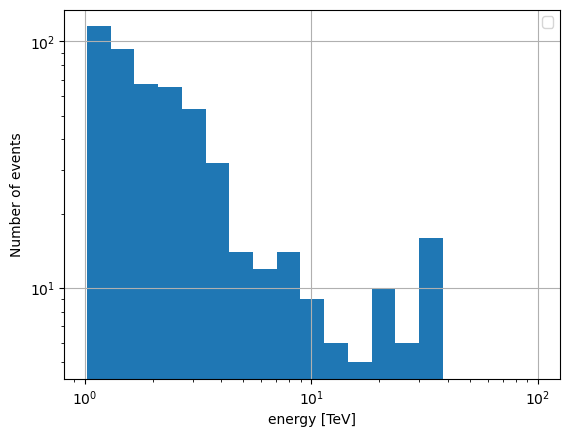

In [42]:
plt.figure()
plt.xlabel('True energy [TeV]')
plt.ylabel('Number of events')
plt.loglog()

plt.hist(data['true_energy'].to_numpy(), bins=np.logspace(0.01, 2, 20), label='')

plt.grid()
plt.legend()